In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

## Load Data

In [26]:
import boto3
from io import BytesIO
from fastparquet import ParquetFile

s3 = boto3.client("s3")
response = s3.list_objects_v2(Bucket='covid-19-prj', Prefix ='raw/health_ministry/')
all_objects = [item.get('Key') for item in response.get('Contents')][1:]

def read_parquet_from_s3(keyName):
    obj = s3.get_object(Bucket='covid-19-prj', Key=keyName)
    df = obj['Body'].read()
    return ParquetFile(BytesIO(df)).to_pandas()

dataframes = [read_parquet_from_s3(key_name) for key_name in all_objects]
df = pd.concat(dataframes, axis=0)

## Overview

In [47]:
df.head()

,region,state,date,New cases,Accumulated cases,New deaths,Accumulated deaths
index,,,,,,,
0,Norte,RO,2020-01-30,0,0,0,0
2548,Centro-Oeste,DF,2020-01-30,0,0,0,0
2450,Centro-Oeste,GO,2020-01-30,0,0,0,0
2352,Centro-Oeste,MT,2020-01-30,0,0,0,0
2254,Centro-Oeste,MS,2020-01-30,0,0,0,0


In [28]:
# Rename columns
df.columns = [
    'region',
    'state',
    'date',
    'New cases',
    'Accumulated cases',
    'New deaths',
    'Accumulated deaths'
]

In [29]:
df.head()

,region,state,date,New cases,Accumulated cases,New deaths,Accumulated deaths
index,,,,,,,
0,Norte,RO,2020-01-30,0,0,0,0
98,Norte,AC,2020-01-30,0,0,0,0
196,Norte,AM,2020-01-30,0,0,0,0
294,Norte,RR,2020-01-30,0,0,0,0
392,Norte,PA,2020-01-30,0,0,0,0


In [30]:
df.describe()

,New cases,Accumulated cases,New deaths,Accumulated deaths
count,2646.000000,2646.000000,2646.000000,2646.000000
mean,47.323507,646.865079,3.226002,41.890023
std,178.954664,2476.755374,14.084123,198.887175
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.000000,0.000000,0.000000
75%,24.000000,274.000000,1.000000,9.000000
max,3800.000000,37853.000000,224.000000,3045.000000


In [31]:
df.dtypes

region                object
state                 object
date                  object
New cases              int64
Accumulated cases      int64
New deaths             int64
Accumulated deaths     int64
dtype: object

In [32]:
# Take a look at the date type
np.array([isinstance(x, str) for x in df.date]).all()

True

## EDA

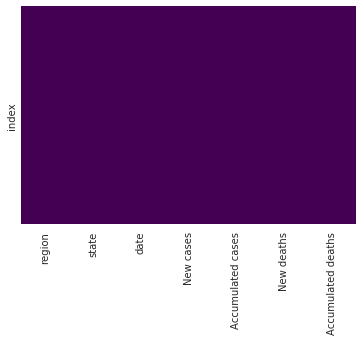

In [33]:
# Missing values
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [34]:
# For more details
display(df.isnull().sum().sort_values(ascending=False))

Accumulated deaths    0
New deaths            0
Accumulated cases     0
New cases             0
date                  0
state                 0
region                0
dtype: int64

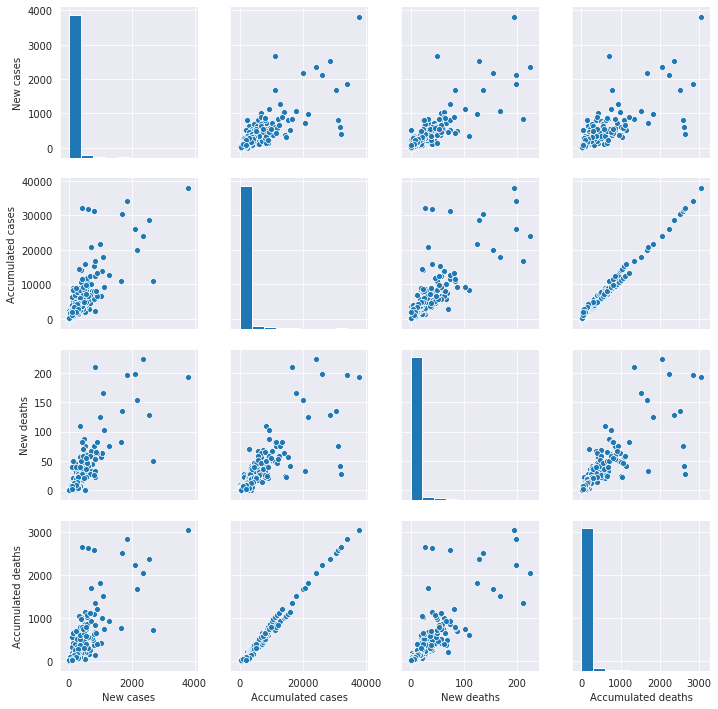

In [35]:
sns.set_style("darkgrid")
sns.pairplot(df[df.columns[-4:]])

In [36]:
# Unify the date column format
df['date'] = pd.to_datetime(df.date).dt.date
# Sort dates
df = df.sort_values('date')
cumulated = df.groupby('date').agg({'New cases': 'sum',
                                    'New deaths': 'sum',
                                    'Accumulated cases': 'sum', 
                                    'Accumulated deaths': 'sum'}).reset_index()

In [54]:
cumulated.describe()

,New cases,New deaths,Accumulated cases,Accumulated deaths
count,98.000000,98.000000,98.000000,98.000000
mean,1277.734694,87.102041,17465.357143,1131.030612
std,2086.986772,146.934763,30317.937075,2090.127680
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,165.000000,2.500000,524.500000,5.000000
75%,1819.250000,114.750000,21808.500000,1198.250000
max,10503.000000,615.000000,125218.000000,8536.000000


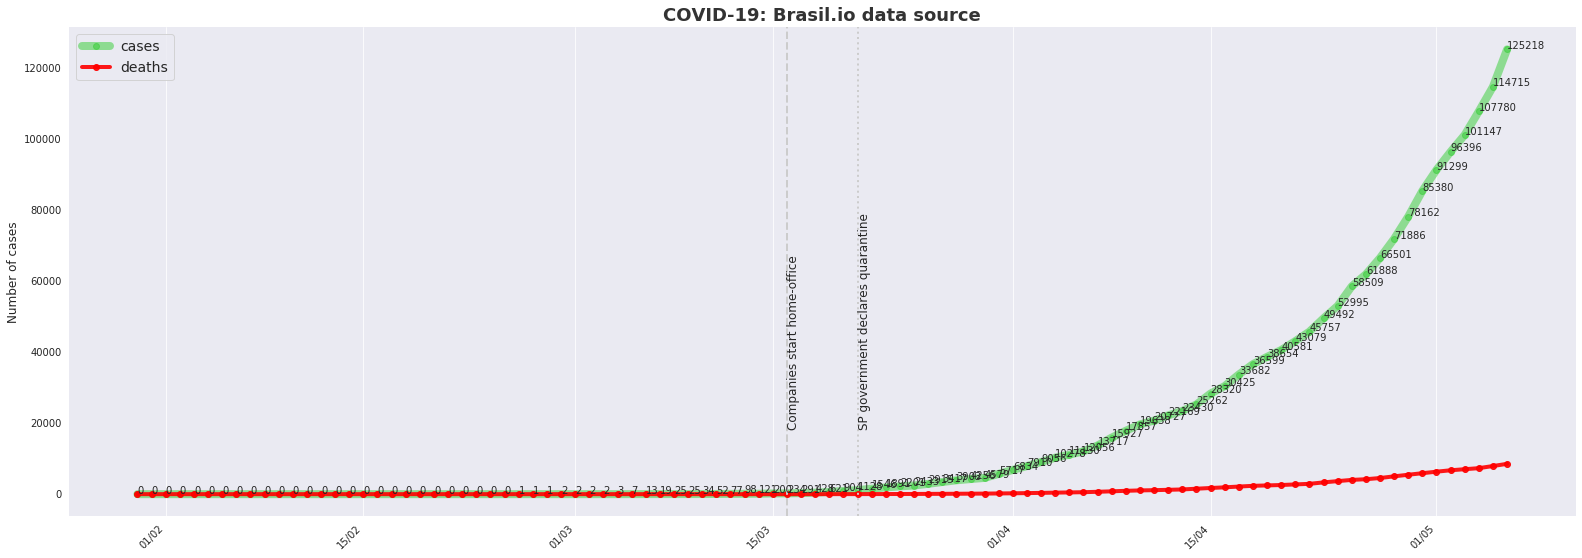

In [37]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
%matplotlib inline

fig, ax = plt.subplots(figsize=(27, 9))

plt.plot(cumulated['date'], cumulated['Accumulated cases'], color='limegreen', linewidth=8, alpha=0.5, marker='o')
plt.plot(cumulated['date'], cumulated['Accumulated deaths'], color='red', linewidth=4, alpha=0.9, marker='o')


[ax.annotate('%s' % y, xy=(x,y+100), fontsize=10) for x,y in zip(cumulated['date'], cumulated['Accumulated cases'])]

plt.xticks(rotation=45, ha='right')
plt.title('COVID-19: Brasil.io data source', fontsize=18, fontweight='bold', color='#333333')

plt.ylabel('Number of cases', fontsize=12)
plt.xlabel(None)

plt.axvline('2020-03-16', 0, 1200, c='#CCCCCC', linestyle='--', linewidth=2, alpha=1)
ax.annotate('Companies start home-office', xy=('2020-03-16',19000), fontsize=12, rotation=90)
plt.axvline('2020-03-21', 0, 1200, c='#CCCCCC', linestyle='dotted', linewidth=2, alpha=1)
ax.annotate('SP government declares quarantine', xy=('2020-03-21',19000), fontsize=12, rotation=90)

plt.legend(loc=2, labels=['cases','deaths'], fontsize=14)

plt.grid(which='major', axis='y')
[ax.spines[side].set_visible(False) for side in ['left','right','top']]
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.show();

In [51]:
np.all(np.diff(cumulated['Accumulated cases']) > 0)

False

In [39]:
np.all(np.diff(cumulated['Accumulated deaths']) > 0)

False

*The number of cases must be incremented, which is not our case*

### Confirmed cases distribution

[Text(0.5, 0, '')]

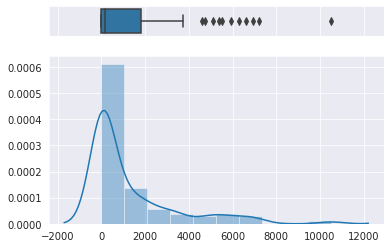

In [56]:
confirmed_cases = cumulated['New cases'].values

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.set_style("darkgrid")
sns.boxplot(confirmed_cases, ax=ax_box)
sns.distplot(confirmed_cases, bins=10, ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

### Death cases distribution

[Text(0.5, 0, '')]

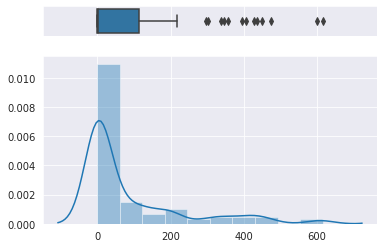

In [57]:
deaths_cases = cumulated['New deaths'].values

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.set_style("darkgrid")
sns.boxplot(deaths_cases, ax=ax_box)
sns.distplot(deaths_cases, bins=10, ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [16]:
# Let's take a look at the number of cities per date
#y = df.groupby('date').agg({'city': (lambda x: x.nunique())})
#sns.distplot(y.city, bins=10)